<a href="https://colab.research.google.com/github/cvankir2/GenreClassification/blob/main/CNNGenreClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Introduction to Neural Networks (CSE 40868/60868)
# University of Notre Dame
# Music Genre Classification 
# CNN 

### Step 1: Load Pytorch and other packages

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize
from torchvision.transforms import CenterCrop
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import pandas as pd

from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
import torch.nn.functional as F


### Step 2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/Shareddrives', force_remount = True)

Mounted at /content/Shareddrives


In [ ]:
cd Shareddrives/Shareddrives/'Neural Networks Project!'/CNN

/content/Shareddrives/Shareddrives/Neural Networks Project!/CNN


## Task 1: Building and training a Convolutional Neural Network

### Step 3: Build the CNN class defining our network

In [ ]:
class CNN(nn.Module):

    def __init__(self, numChannels, numClasses):
        super(CNN, self).__init__()
        self.classes = numClasses

        self.conv1 = nn.Conv2d(numChannels, numClasses, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 124 * 92, 128)
        self.fc2 = nn.Linear(128, numClasses)


    # Evaluation function
    def evaluate(self, model, dataloader, classes, device):

        # We need to switch the model into the evaluation mode
        model.eval()
        
        # Prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        # For all test data samples:
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            images = images.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            predictions = predictions.detach().cpu().numpy()

            # Count the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                
                # If you want to see real and predicted labels for all samples:
                # print("Real class: " + classes[label] + ", predicted = " + classes[prediction])
                
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

        # Calculate the overall accuracy on the test set
        acc = sum(correct_pred.values()) / sum(total_pred.values())

        return acc


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 124 * 92)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

### Step 4: Split data.

In [ ]:
import ast
import matplotlib.image as img
from PIL import Image
import cv2

In [ ]:
def load(filepath):
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                ('track', 'genres'), ('track', 'genres_all')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                ('album', 'date_created'), ('album', 'date_released'),
                ('artist', 'date_created'), ('artist', 'active_year_begin'),
                ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    try:
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)
    except (ValueError, TypeError):
        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                  pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                ('album', 'type'), ('album', 'information'),
                ('artist', 'bio')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks


In [ ]:
class MusicDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        i, label = self.data[index]
        sid = str(i).zfill(6)
        img_path = os.path.join(self.path, sid+".png")
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        height, width, channels = image.shape
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
tracks = pd.read_csv('../spectrograms.csv')

In [ ]:
labels = tracks.dropna()
labels['genre'] = pd.factorize(labels['genre_top'])[0]
genre_id = labels[['genre','genre_top']].drop_duplicates()
labels = labels[['track_id','genre']]
classes = genre_id['genre_top'].tolist()
print(labels.head())
print(genre_id)

   track_id  genre
0         2      0
1         5      0
2        10      1
3       140      2
4       141      2
     genre      genre_top
0        0        Hip-Hop
2        1            Pop
3        2           Folk
5        3   Experimental
6        4           Rock
37       5  International
83       6     Electronic
408      7   Instrumental


In [ ]:
epochs = 20
batch_size = 80

train_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

train_path = '../Spectrograms'

train, test_data = train_test_split(labels, test_size=0.2)
train_data, valid_data = train_test_split(train, test_size=0.2)

test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
valid_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

# Load dataset
train_data = MusicDataset(train_data, train_path, train_transform)
val_data = MusicDataset(valid_data, train_path, valid_transform )
test_data = MusicDataset(test_data, train_path, test_transform )


# Prepare data loaders for train, validation and test data splits 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

In [ ]:
classes

['Hip-Hop',
 'Pop',
 'Folk',
 'Experimental',
 'Rock',
 'International',
 'Electronic',
 'Instrumental']

### Step 5: Train or evaluate 

In [ ]:
if __name__ == '__main__':

    # Specify the operation mode:
    # 'train' = training with your train and validation data splits
    # 'eval'  = evaluation of the trained model with your test data split 
    mode = 'eval'#eval'

    # Path where you plan to save the best model during training
    my_best_model = "models/CNN2_sgd_lr01_best_model.pth"

    # Set the device (GPU or CPU, depending on availability)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Currently using device: ", device)

    # Initialize the model and print out its configuration
    model = CNN(numChannels = 3, numClasses = 8)
    model.to(device)

    print("\n\nModel summary:\n\n")
    summary(model, input_size=(3, 496, 369))

    if mode == "train":

        print("\n\nTraining starts!\n\n")
        
        model.train()
        criterion = nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        running_loss = .0
        best_acc = .0
        for epoch in range(epochs):
            print(f"Starting epoch {epoch + 1}")
            for idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):

                # Get the inputs (data is a list of [inputs, labels])
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                loss = loss.detach().cpu().numpy()
                inputs = inputs.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()
                running_loss += loss

            # Evaluate the accuracy after each epoch
            acc = model.evaluate(model, val_loader, classes, device)
            if acc > best_acc:
                print(f"Better validation accuracy achieved: {acc * 100:.2f}%")
                best_acc = acc
                print(f"Saving this model as: {my_best_model}")
                torch.save(model.state_dict(), my_best_model)

    # And here we evaluate the trained model with the test data
    elif mode == "eval":

        print("\n\nValidating the trained model:")
        print(f"Loading checkpoint from {my_best_model}")
        model.load_state_dict(torch.load(my_best_model))
        acc = model.evaluate(model, test_loader, classes, device)
        print(f"Accuracy on the test (unknown) data: {acc * 100:.2f}%")

    else:
        print("'mode' argument should either be 'train' or 'eval'")

Currently using device:  cuda:0


Model summary:


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 496, 369]             224
         MaxPool2d-2          [-1, 8, 248, 184]               0
            Conv2d-3         [-1, 32, 248, 184]           2,336
         MaxPool2d-4          [-1, 32, 124, 92]               0
            Linear-5                  [-1, 128]      46,727,296
            Linear-6                    [-1, 8]           1,032
Total params: 46,730,888
Trainable params: 46,730,888
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.09
Forward/backward pass size (MB): 27.88
Params size (MB): 178.26
Estimated Total Size (MB): 208.24
----------------------------------------------------------------


Validating the trained model:
Loading checkpoint from models/CNN2_sgd_lr01_best_model.pth


KeyboardInterrupt: ignored

### Step 6: Visual Data

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt


currently using:  cuda:0
Successfully loaded the model checkpoint!


100%|██████████| 28/28 [08:29<00:00, 18.21s/it]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2192 samples in 0.003s...
[t-SNE] Computed neighbors for 2192 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2192
[t-SNE] Computed conditional probabilities for sample 2000 / 2192
[t-SNE] Computed conditional probabilities for sample 2192 / 2192
[t-SNE] Mean sigma: 0.488462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.483704
[t-SNE] KL divergence after 1000 iterations: 0.943011


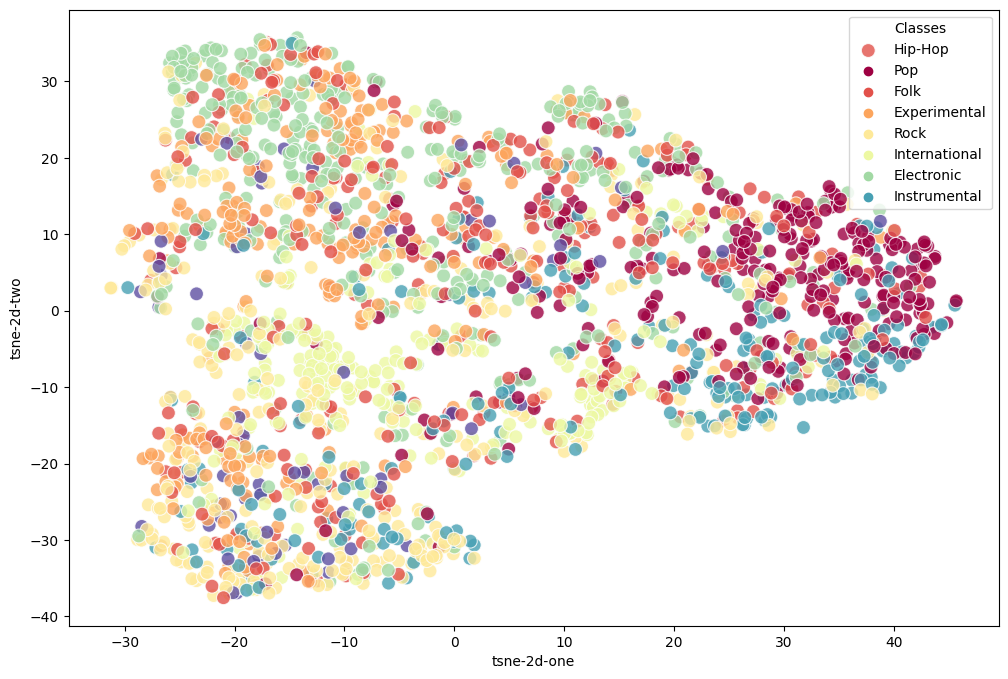

<Figure size 640x480 with 0 Axes>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("currently using: ", device)
# Initialize the model and print out its configuration
model = CNN(numChannels = 3, numClasses = 8)
model.to(device)

# Provide correct path to the weights:
my_weights = "models/CNN2_sgd_lr01_best_model.pth"


################################################################################


model.load_state_dict(torch.load(my_weights))
print("Successfully loaded the model checkpoint!")

# Get the encodings for your sample data
for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):

    # Get the inputs (data is a list of [inputs, labels])
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Get the features (encodings) from the one-before-last fully-connected layer 
    # in our Convolutional Neural Network:
    with torch.no_grad():
      enc = model(inputs)
    enc = enc.detach().cpu().numpy()
    inputs = inputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    if idx == 0:
        labels_all = labels
        enc_all = enc
    else:
        enc_all = np.vstack((enc_all, enc))
        labels_all = np.hstack((labels_all, labels))

# t-SNE (selected) hyperparameters
perplexity = 50
n_iter = 1000

# Run the t-SNE for the encodings you extracted 
tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
tsne_results = tsne.fit_transform(enc_all)
class_names = [classes[i] for i in labels_all]
feat_cols = ['pixel'+str(i) for i in range(enc.shape[1])]

# Visualize the t-SNE projection to 2 dimensions
df = pd.DataFrame(enc_all, columns = feat_cols)
df['labels'] = labels_all
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(12,8))
ax = sns.scatterplot(
    data=df,                
    x="tsne-2d-one", 
    y="tsne-2d-two",
    s=100,                  # marker size
    hue="labels",
    palette=sns.color_palette(palette="Spectral", as_cmap=True, n_colors=10),
    legend="full",
    alpha=0.8,
)

plt.legend(title='Classes', labels=classes)
plt.show(ax)
plt.savefig('tSNE.png')